<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Capstone Project - The Battle of Neighborhoods</font></h1>


## Introduction

New York City (NYC) is one of the most energy-intensive urban environments in the world. The peak summer load of NYC approaches 14 GW of demand — almost a quarter of the peak demand in all of California. In addition, while nearly 60 percent of the state’s electricity is consumed in the NYC, only 40 percent of it is generated there. This urban grid delivers energy primarily through an underground network, which makes managing and maintaining the system an expensive and challenging endeavor to continue to meet the rapidly growing peak load. As part of the solution—and as an alternative to building out traditional grid infrastructure, New York is looking at local generation and storage options to cover peak load, optimize delivery systems, and make the grid more efficient and reliable.

The availability of reliable, resilient, and affordable electric service is critical to the welfare of NYC citizens and is central to New York’s economy. To ensure continuing economic growth and prosperity for New York, the state laid out an ambitious energy agenda.  Through “Reforming the Energy Vision” (REV) strategy, New York is actively spurring clean energy innovation, bringing new investments into the State and improving consumer choice and affordability. Regulatory changes under the REV initiative are promoting more efficient use of energy, deeper penetration of renewable energy resources such as wind and solar, wider deployment of “distributed” energy resources, such as micro grids, roof-top solar and other on-site power supplies, and storage. It is also promoting markets to achieve greater use of advanced energy management products to enhance demand elasticity and efficiencies. These changes, in turn, will empower customers by allowing them more choice in how they manage and consume electric energy.

This transition to cleaner, more reliable and distributed energy resources presents great opportunities for energy efficiency service probivers, and solar and battery storage companies to tranform the electric grid of NY. So as part of this project , we will list and visualize all major parts of New York City that has large electric loads that are favorable targets to the energy service companies. 

## Data

For this project we need the following data :

- New York City data that contains list of Boroughs, Neighborhoods along with their latitude and longitude.
    - Data source : https://cocl.us/new_york_dataset
    - Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.

- Large electric loads in each neighborhood of new york city.
    - Data source : Fousquare API
    - Description : By using this api we will get all the venues in each neighborhood. We will filter these to get information for schools, universities, hospitals, super markets, and outlet malls etc.  

- GeoSpace data
    - Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
    - Description : By using this data we will get the New york Borough boundaries that will help us in visualizing choropleth map.

### How the data will be used?

- Collect the new york city data from https://cocl.us/new_york_dataset
- Use FourSquare API to find all venues for each neighborhood
- Filter out all large electric loads
- Find rating , tips and like count for large loads using FourSquare API. This information is used as a proxy for the profitability and finanical strength of these entities
- Sort the data based on rating
- Visualize the Ranking of neighborhoods using folium library(python)

### What all we will get?

- Areas that are favorable targets for energy service companies
- Equipped with this information, the energy service companies will be able to tailor and develop efficient sales and marketing strategies 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
#import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

### Get latitude and longitude of a given location

In [2]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Get venue information from FourSquare

In [3]:
def get_venues(lat,lng):
    
    radius=1000
    LIMIT=100
    CLIENT_ID = 'VWLLWX2I0GCBPDIF1A3URTZG1D3NF4XGLENBUX5NXT0KXSIF' # your Foursquare ID
    CLIENT_SECRET = '22M0U5UJBZMOMMR0SSUVVWC5SAI5S3FKT3MSUGZMITY1L5F1' # your Foursquare Secret
    VERSION = '20201208' 
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    if 'groups' not in results["response"]:
        return pd.DataFrame()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Get venue details from FourSquare

In [4]:
def get_venue_details(venue_id):
    CLIENT_ID = 'VWLLWX2I0GCBPDIF1A3URTZG1D3NF4XGLENBUX5NXT0KXSIF' # your Foursquare ID
    CLIENT_SECRET = '22M0U5UJBZMOMMR0SSUVVWC5SAI5S3FKT3MSUGZMITY1L5F1' # your Foursquare Secret
    VERSION = '20201208'
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    print(results['response'].keys())
    if 'venue' not in results['response'].keys():
        return pd.DataFrame()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Get New York City Data

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [8]:
new_york_data.shape

(306, 4)

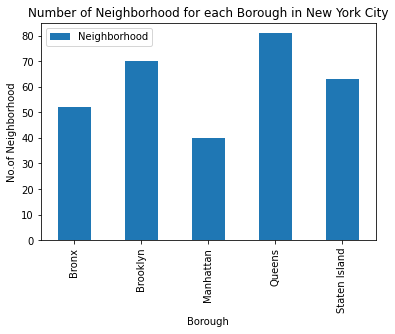

In [9]:
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough')
plt.ylabel('No.of Neighborhood')
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

### Get large electric loads for each neighbourhood

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
electric_loads_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude) 
    if venues.empty==False:
        #electric_loads=venues[venues['Category']=='School']   
        electric_loads = venues[(venues.Category == 'Shop & Service') | (venues.Category == 'School') | (venues.Category == 'Outdoors & Recreation') | (venues.Category == 'Food & Drink Shop') | (venues.Category == 'Government Building') | (venues.Category == 'Medical Center') | (venues.Category == 'College & University') | (venues.Category == 'Event') | (venues.Category == 'Stadium')  | (venues.Category == 'Arts & Entertainment') | (venues.Category == 'Travel & Transport')]
        print('(',count,'/',len(new_york_data),')','Large electric loads '+Neighborhood+', '+Borough+':'+str(len(electric_loads)))
        for load_detail in electric_loads.values.tolist():
            id, name , category=load_detail
            electric_loads_ny = electric_loads_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name
                                                }, ignore_index=True)
        count+=1

( 1 / 306 ) Large electric loads Wakefield, Bronx:0
( 2 / 306 ) Large electric loads Co-op City, Bronx:0
( 3 / 306 ) Large electric loads Eastchester, Bronx:1
( 4 / 306 ) Large electric loads Fieldston, Bronx:0
( 5 / 306 ) Large electric loads Riverdale, Bronx:0
( 6 / 306 ) Large electric loads Kingsbridge, Bronx:0
( 7 / 306 ) Large electric loads Marble Hill, Manhattan:0
( 8 / 306 ) Large electric loads Woodlawn, Bronx:0
( 9 / 306 ) Large electric loads Norwood, Bronx:0
( 10 / 306 ) Large electric loads Williamsbridge, Bronx:0
( 11 / 306 ) Large electric loads Baychester, Bronx:1
( 12 / 306 ) Large electric loads Pelham Parkway, Bronx:0
( 13 / 306 ) Large electric loads City Island, Bronx:0
( 14 / 306 ) Large electric loads Bedford Park, Bronx:0
( 15 / 306 ) Large electric loads University Heights, Bronx:0
( 16 / 306 ) Large electric loads Morris Heights, Bronx:0
( 17 / 306 ) Large electric loads Fordham, Bronx:1
( 18 / 306 ) Large electric loads East Tremont, Bronx:0
( 19 / 306 ) Lar

( 143 / 306 ) Large electric loads Maspeth, Queens:0
( 144 / 306 ) Large electric loads Ridgewood, Queens:0
( 145 / 306 ) Large electric loads Glendale, Queens:1
( 146 / 306 ) Large electric loads Rego Park, Queens:0
( 147 / 306 ) Large electric loads Woodhaven, Queens:0
( 148 / 306 ) Large electric loads Ozone Park, Queens:2
( 149 / 306 ) Large electric loads South Ozone Park, Queens:0
( 150 / 306 ) Large electric loads College Point, Queens:1
( 151 / 306 ) Large electric loads Whitestone, Queens:0
( 152 / 306 ) Large electric loads Bayside, Queens:0
( 153 / 306 ) Large electric loads Auburndale, Queens:0
( 154 / 306 ) Large electric loads Little Neck, Queens:1
( 155 / 306 ) Large electric loads Douglaston, Queens:1
( 156 / 306 ) Large electric loads Glen Oaks, Queens:0
( 157 / 306 ) Large electric loads Bellerose, Queens:1
( 158 / 306 ) Large electric loads Kew Gardens Hills, Queens:0
( 159 / 306 ) Large electric loads Fresh Meadows, Queens:0
( 160 / 306 ) Large electric loads Briarw

( 280 / 306 ) Large electric loads Fulton Ferry, Brooklyn:0
( 281 / 306 ) Large electric loads Vinegar Hill, Brooklyn:0
( 282 / 306 ) Large electric loads Weeksville, Brooklyn:0
( 283 / 306 ) Large electric loads Broadway Junction, Brooklyn:0
( 284 / 306 ) Large electric loads Dumbo, Brooklyn:0
( 285 / 306 ) Large electric loads Manor Heights, Staten Island:0
( 286 / 306 ) Large electric loads Willowbrook, Staten Island:0
( 287 / 306 ) Large electric loads Sandy Ground, Staten Island:0
( 288 / 306 ) Large electric loads Egbertville, Staten Island:0
( 289 / 306 ) Large electric loads Roxbury, Queens:0
( 290 / 306 ) Large electric loads Homecrest, Brooklyn:1
( 291 / 306 ) Large electric loads Middle Village, Queens:0
( 292 / 306 ) Large electric loads Prince's Bay, Staten Island:0
( 293 / 306 ) Large electric loads Lighthouse Hill, Staten Island:0
( 294 / 306 ) Large electric loads Richmond Valley, Staten Island:0
( 295 / 306 ) Large electric loads Malba, Queens:0
( 296 / 306 ) Large ele

In [11]:
electric_loads_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Eastchester,4dd8039c1838b8561cf60dec,Imperial beverage center
1,Bronx,Baychester,4c588763ec2520a191df4c12,Gunhill Wholesale
2,Bronx,Fordham,4bc3acdc74a9a593ebebd4f6,Teitel Brothers Imported Italian Specialty Pro...
3,Bronx,Port Morris,4f39467ae4b039c3c45d8406,Mott Haven Charter School
4,Bronx,Hunts Point,4c3a5ededfb0e21e1c24b2a8,Meat Market - Hunts Point


In [12]:
electric_loads_ny.shape

(86, 4)

### Chart large electric loads for each Borough

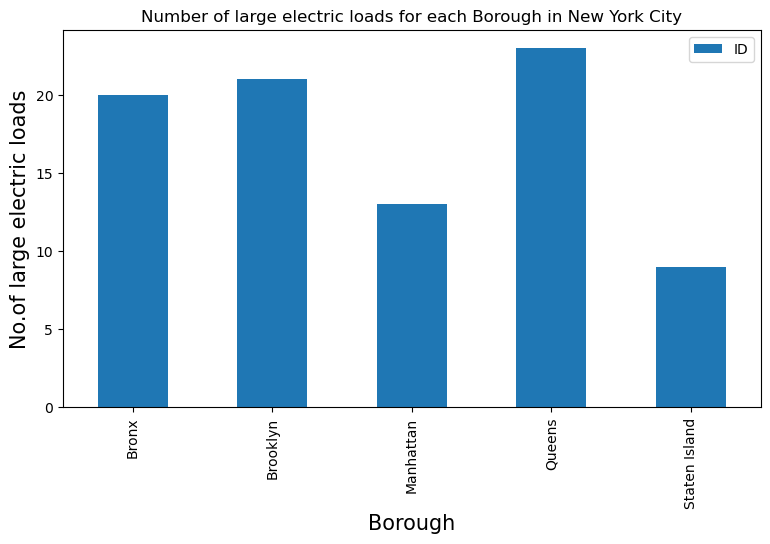

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of large electric loads for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of large electric loads', fontsize=15)
electric_loads_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
#displays the plot
plt.show()

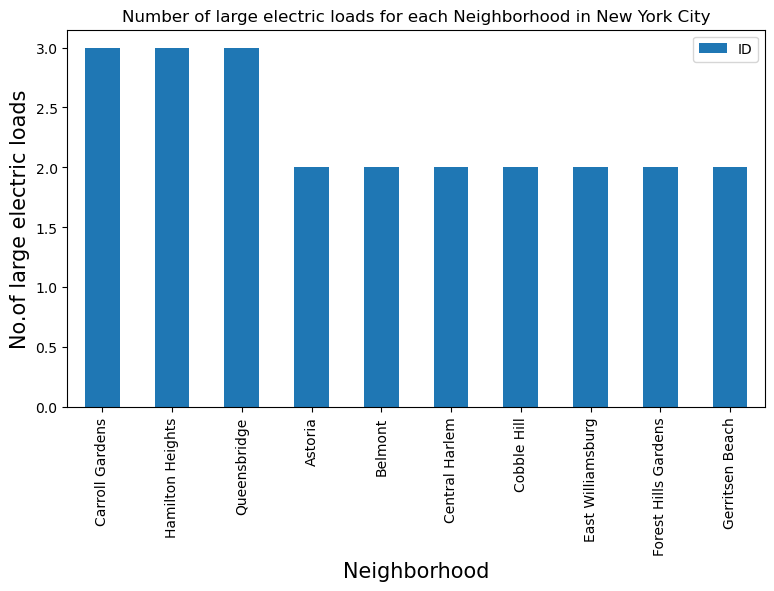

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of large electric loads for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of large electric loads', fontsize=15)
electric_loads_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
plt.legend()
plt.show()

In [15]:
electric_loads_ny[electric_loads_ny['Neighborhood']=='Carroll Gardens']

,Borough,Neighborhood,ID,Name
28,Brooklyn,Carroll Gardens,4a59edcaf964a52091b91fe3,K&Y Fruit and Veggie
29,Brooklyn,Carroll Gardens,4c5dbf402815c928c8c3b567,Court Street Grocers
30,Brooklyn,Carroll Gardens,51365533582f411c528d0dcb,Poppy's Catering + Events


### Get rankings of each electric load. We will use these as a proxy for profitability and financial strength of the business

In [16]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
electric_loads_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in electric_loads_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these large electric loads as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(electric_loads_ny),')','processed')
    electric_loads_stats_ny = electric_loads_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
electric_loads_stats_ny.tail()

dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4dd8039c1838b8561cf60dec
( 1 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4c588763ec2520a191df4c12
( 2 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4bc3acdc74a9a593ebebd4f6
( 3 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4f39467ae4b039c3c45d8406
( 4 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4c3a5ededfb0e21e1c24b2a8
( 5 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4c90e6ed238c6dcbc45cbb55
( 6 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4b5f7736f964a520febb29e3
( 7 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 597643b94c9be61d2685a28f
( 8 / 86 ) processed
dict_key

dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4bdc80363904a593dc784e9e
( 67 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4ce7e860b9975481c626f944
( 68 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4bb35a92715eef3bd23186bb
( 69 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4dfbdccab0fb84d7acde468e
( 70 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4b79c997f964a5200a122fe3
( 71 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4db1ecec1e729fcc565dbcad
( 72 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4e2f4bc814953296330354f2
( 73 / 86 ) processed
dict_keys([])
Empty DataFrame
Columns: []
Index: []
No data available for id= 4ceda0093b03f04d196b35dc
( 74 / 86 ) processed


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
81,Brooklyn,Homecrest,0,0,0,0,0
82,Brooklyn,Erasmus,0,0,0,0,0
83,Queens,Queensbridge,0,0,0,0,0
84,Queens,Queensbridge,0,0,0,0,0
85,Queens,Queensbridge,0,0,0,0,0


In [17]:
electric_loads_stats_ny.head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,0,0,0,0,0
1,Bronx,Baychester,0,0,0,0,0
2,Bronx,Fordham,0,0,0,0,0
3,Bronx,Port Morris,0,0,0,0,0
4,Bronx,Hunts Point,0,0,0,0,0
5,Bronx,Soundview,0,0,0,0,0
6,Bronx,Country Club,0,0,0,0,0
7,Bronx,Parkchester,0,0,0,0,0
8,Bronx,Westchester Square,0,0,0,0,0
9,Bronx,Van Nest,0,0,0,0,0


In [18]:
electric_loads_stats_ny.shape

(86, 7)

In [19]:
electric_loads_stats_ny.to_csv('electric_loads_stats_ny.csv', index=False)

In [20]:
electric_loads_stats_ny=pd.read_csv('electric_loads_stats_ny.csv')

In [21]:
electric_loads_stats_ny.shape

(86, 7)

In [22]:
electric_loads_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       86 non-null     object
 1   Neighborhood  86 non-null     object
 2   ID            86 non-null     int64 
 3   Name          86 non-null     int64 
 4   Likes         86 non-null     int64 
 5   Rating        86 non-null     int64 
 6   Tips          86 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 4.8+ KB


In [23]:
electric_loads_stats_ny['Likes']=electric_loads_stats_ny['Likes'].astype('float64')
electric_loads_stats_ny['Tips']=electric_loads_stats_ny['Tips'].astype('float64')
electric_loads_stats_ny['Rating']=electric_loads_stats_ny['Rating'].astype('float64')
electric_loads_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       86 non-null     object 
 1   Neighborhood  86 non-null     object 
 2   ID            86 non-null     int64  
 3   Name          86 non-null     int64  
 4   Likes         86 non-null     float64
 5   Rating        86 non-null     float64
 6   Tips          86 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 4.8+ KB


### Business with maximum Likes

In [24]:
electric_loads_stats_ny.iloc[electric_loads_stats_ny['Likes'].idxmax()]

Borough               Bronx
Neighborhood    Eastchester
ID                        0
Name                      0
Likes                     0
Rating                    0
Tips                      0
Name: 0, dtype: object

### Business with maximum Rating

In [25]:
electric_loads_stats_ny.iloc[electric_loads_stats_ny['Rating'].idxmax()]

Borough               Bronx
Neighborhood    Eastchester
ID                        0
Name                      0
Likes                     0
Rating                    0
Tips                      0
Name: 0, dtype: object

### Business with maximum Tips

In [26]:
electric_loads_stats_ny.iloc[electric_loads_stats_ny['Tips'].idxmax()]

Borough               Bronx
Neighborhood    Eastchester
ID                        0
Name                      0
Likes                     0
Rating                    0
Tips                      0
Name: 0, dtype: object

### Neighborhood Visualisation with Max average rating

In [27]:
ny_neighborhood_stats=electric_loads_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Arrochar,0.0
33,Homecrest,0.0
35,Hunts Point,0.0
36,Jackson Heights,0.0
37,Kensington,0.0
38,Kew Gardens,0.0
39,Little Neck,0.0
40,Long Island City,0.0
41,Manhattanville,0.0
42,Midwood,0.0


### Visualisation of Average Rating for each Borough

In [28]:
ny_borough_stats=electric_loads_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
0,Bronx,0.0
1,Brooklyn,0.0
2,Manhattan,0.0
3,Queens,0.0
4,Staten Island,0.0


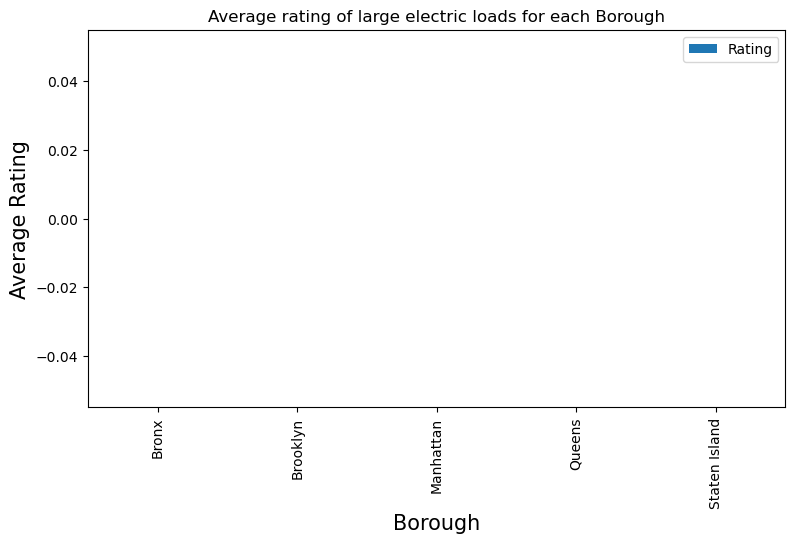

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of large electric loads for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
electric_loads_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')#legend
plt.legend()
plt.show()

#### Neigborhoods with average rating greater than 8.0

In [30]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating


In [31]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating


### Visualizing the Neigborhoods

In [32]:
#!pip install folium
import folium
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [33]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Conclusion

- Queens and Brooklyn have the highest number of "large electric loads"
- The neighborhoods that have the highest businesses are Carroll Garden, Hamilton Heights, and Queens Bridge
- An energy service provider is well advised to focus on the top boroughs and neighborhoods to sell energy services such as energy efficiency, distributed energy resources, and energy storage solutions to lower the the energy costs for these businesses and contribute to the state and city's goals of cleaner, local and sustainable energy supply. 
- The NY REV program provides various incentives for the businesses to adopt these technologies
- Additional marketing insights can be developed by performing additional clustering of business types and tailoring the solutions for business types

## Limitations

- Limited information available for businesses other than restuarants in Foursqure
- This has impacted identifying all the large electric loads that are attractive business opportunities for energy service providers
- Rating was used as a proxy for estimating the size, profitability of businesses. This might is not always true. But this was best workaround for using the FourSquare information for the purpose of the project 